In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import statsmodels.stats.api as sms

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing  import  StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from scipy.stats import jarque_bera

import warnings
warnings.filterwarnings("ignore")

In [3]:
pd.set_option('max_columns', None)

## 1 - Predição de pagamento de empréstimos

Vamos realizar alguns processos de limpeza e padronização dos dados pra facilitar a manipulação 

In [3]:
#nome das colunas
columns_cred = ['ESCT','NDEP','RENDA','TIPOR','VBEM','NPARC','VPARC','TEL','IDADE','RESMS','ENTRADA','CLASSE']

In [4]:
#leitura dos dados
raw_train = pd.read_csv('dados/credtrain.txt',sep = '\t', header=None, names = columns_cred)
raw_test = pd.read_csv('dados/credtest.txt',sep = '\t', header=None, names = columns_cred)

In [5]:
#lower nas colunas pra melhor manipulação
raw_train.columns = [x.lower() for x in raw_train.columns]
raw_test.columns = [x.lower() for x in raw_test.columns]

In [6]:
df_train = raw_train.copy()
df_test = raw_test.copy()

In [7]:
df_train.head()

,esct,ndep,renda,tipor,vbem,nparc,vparc,tel,idade,resms,entrada,classe
0,1,0,360,0,313,9,52,0,25,48,0,1
1,0,0,350,1,468,10,65,0,33,6,0,1
2,0,0,1100,0,829,9,125,0,56,48,0,1
3,0,0,3000,0,552,12,76,1,31,60,0,1
4,1,0,1000,0,809,12,111,0,24,7,0,1


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   esct     1500 non-null   int64
 1   ndep     1500 non-null   int64
 2   renda    1500 non-null   int64
 3   tipor    1500 non-null   int64
 4   vbem     1500 non-null   int64
 5   nparc    1500 non-null   int64
 6   vparc    1500 non-null   int64
 7   tel      1500 non-null   int64
 8   idade    1500 non-null   int64
 9   resms    1500 non-null   int64
 10  entrada  1500 non-null   int64
 11  classe   1500 non-null   int64
dtypes: int64(12)
memory usage: 140.8 KB


In [9]:
df_train.classe.value_counts()

0    785
1    715
Name: classe, dtype: int64

In [10]:
#criando categórica pra classe

df_train['classe_cat'] = "não pagou"
df_train.loc[df_train.classe == 1, 'classe_cat'] = "pagou"

Algumas visualizações que trazem insights

Text(0, 0.5, 'idade')

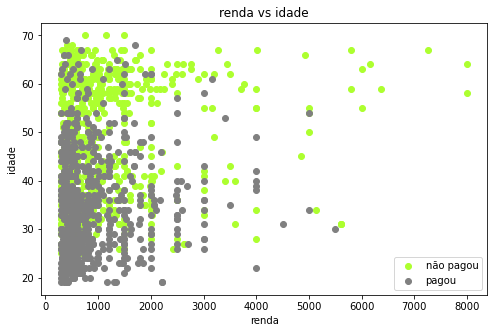

In [11]:
tags_grupos = df_train.classe.unique()
tags_grupos.sort()
colors = ['greenyellow','grey']

#plot dos dados segmentados por grupo (contra usuários)
plt.subplots(figsize=(8, 5))
for n in tags_grupos:
    plt.scatter(df_train.loc[df_train.classe == n].renda, 
                df_train.loc[df_train.classe == n].idade, 
                color=colors[n], 
                marker='o', 
                label = df_train.loc[df_train.classe == n, 'classe_cat'].unique()[0])
plt.title("renda vs idade")
plt.legend(loc="lower right")
plt.xlabel("renda")
plt.ylabel("idade")

Text(0, 0.5, 'valor da entrada')

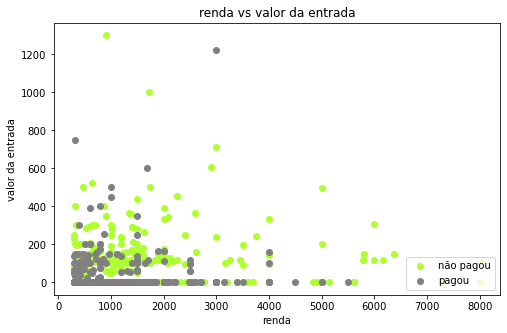

In [12]:
tags_grupos = df_train.classe.unique()
tags_grupos.sort()
colors = ['greenyellow','grey']

#plot dos dados segmentados por grupo (contra usuários)
plt.subplots(figsize=(8, 5))
for n in tags_grupos:
    plt.scatter(df_train.loc[df_train.classe == n].renda, 
                df_train.loc[df_train.classe == n].entrada, 
                color=colors[n], 
                marker='o',
                label = df_train.loc[df_train.classe == n, 'classe_cat'].unique()[0])
plt.title("renda vs valor da entrada")
plt.legend(loc="lower right")
plt.xlabel("renda")
plt.ylabel("valor da entrada")

Text(0, 0.5, 'número de parcelas')

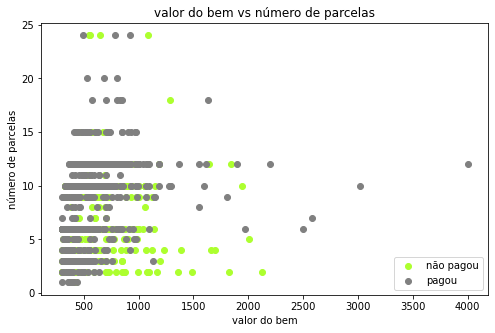

In [54]:
tags_grupos = df_train.classe.unique()
tags_grupos.sort()
colors = ['greenyellow','grey']

#plot dos dados segmentados por grupo (contra usuários)
plt.subplots(figsize=(8, 5))
for n in tags_grupos:
    plt.scatter(df_train.loc[df_train.classe == n].vbem, 
                df_train.loc[df_train.classe == n].nparc, 
                color=colors[n], 
                marker='o',
                label = df_train.loc[df_train.classe == n, 'classe_cat'].unique()[0])
plt.title("valor do bem vs número de parcelas")
plt.legend(loc="lower right")
plt.xlabel("valor do bem")
plt.ylabel("número de parcelas")

### Preparação pro fit

Selecionando variáveis que precisam ser normalizadas e que precisam ser transformadas em dummy

In [13]:
#separando variáveis
target = ['classe']

dep_to_scaler = ['ndep', 'renda', 'vbem', 'nparc', 'vparc','idade', 'resms', 'entrada']
dep_boll = ['tipor','tel']
dep_to_dummy = ['esct']

In [14]:
#variaveis para predição
y_train = df_train[target]
y_test = df_test[target]

X_train = df_train[dep_to_scaler].join(df_train[dep_boll]).join(df_train[dep_to_dummy])
X_test = df_test[dep_to_scaler].join(df_test[dep_boll].join(df_train[dep_to_dummy]))

In [15]:
X_train.shape, X_test.shape

((1500, 11), (577, 11))

Padronização dos dados

In [16]:
#TRANFORMER DEPOIS DO SPLIT PRA NÃO VAZAR DADOS DO TREINO PRO TESTE

#Scaler
scaler_train = StandardScaler()

#variaveis a serem transformadas
var_to_scaler = dep_to_scaler

#selecionando em cada dataset - treino e teste
data_transform_train = X_train[var_to_scaler].copy()
data_transform_test = X_test[var_to_scaler].copy()

#fit transform no dataset de treino e transform no dataset de teste
transformed_train = scaler_train.fit_transform(data_transform_train)
X_train.loc[:, var_to_scaler] = transformed_train

transformed_test = scaler_train.transform(data_transform_test)
X_test.loc[:, var_to_scaler] = transformed_test

Get dummy

In [17]:
X_train = pd.get_dummies(data=X_train, prefix="esct", columns=["esct"], drop_first=True)
X_test = pd.get_dummies(data=X_test, prefix="esct", columns=["esct"], drop_first=True)

### Treino e teste dos modelos

Vamos utilizar diferentes algoritmos de treinamento. Para avaliar cada um deles, vamos utilizar um report com as pricipais métricas de performance e a matriz de confusão - que nos permite avaliar o desempenho de um classificador ao comparar suas previsões com os valores reais. Além disso vamos fazer a validação cruzada pra certificar a capacidade de generalização dos modelos.

#### Random Forest

In [18]:
rfg = RandomForestClassifier(random_state = 1) 
rfg.fit(X_train, y_train)

y_pred = rfg.predict(X_test)

In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       306
           1       0.95      0.83      0.89       271

    accuracy                           0.90       577
   macro avg       0.91      0.90      0.90       577
weighted avg       0.91      0.90      0.90       577



In [20]:
#validação cruzada
X_to_cv = X_train.append(X_test)
y_to_cv = y_train.append(y_test)

scores = cross_val_score(rfg, X_to_cv, y_to_cv, cv=5, scoring='accuracy')

print("acurácia de %0.2f com %0.2f desvios" % (scores.mean(), scores.std()))

acurácia de 0.90 com 0.01 desvios


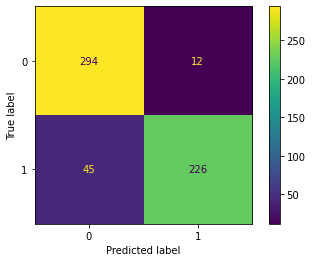

In [21]:
#confusion matrix

cm = confusion_matrix(y_test, y_pred, labels=rfg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rfg.classes_)
disp.plot()
plt.show()

#### Logistic Regression

In [22]:
lr = LogisticRegression(random_state=2)
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

In [23]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90       306
           1       0.93      0.83      0.88       271

    accuracy                           0.89       577
   macro avg       0.90      0.89      0.89       577
weighted avg       0.89      0.89      0.89       577



In [24]:
#validação cruzada
X_to_cv = X_train.append(X_test)
y_to_cv = y_train.append(y_test)

scores = cross_val_score(lr, X_to_cv, y_to_cv, cv=5, scoring='accuracy')

print("acurácia de %0.2f com %0.2f desvios" % (scores.mean(), scores.std()))

acurácia de 0.89 com 0.01 desvios


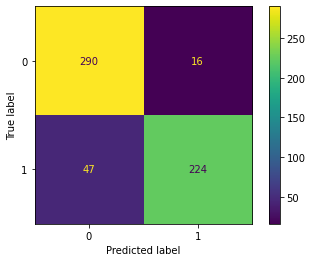

In [25]:
#confusion matrix

cm = confusion_matrix(y_test, y_pred, labels=lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lr.classes_)
disp.plot()
plt.show()

#### Decision Tree

In [26]:
clf_en = DecisionTreeClassifier()

clf_en.fit(X_train,y_train)
y_pred = clf_en.predict(X_test)

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.84      0.85       306
           1       0.83      0.85      0.84       271

    accuracy                           0.85       577
   macro avg       0.85      0.85      0.85       577
weighted avg       0.85      0.85      0.85       577



In [28]:
#validação cruzada
X_to_cv = X_train.append(X_test)
y_to_cv = y_train.append(y_test)

scores = cross_val_score(clf_en, X_to_cv, y_to_cv, cv=5, scoring='accuracy')

print("acurácia de %0.2f com %0.2f desvios" % (scores.mean(), scores.std()))

acurácia de 0.85 com 0.01 desvios


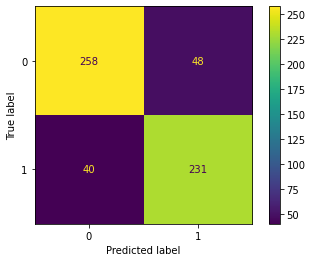

In [29]:
#confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=clf_en.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf_en.classes_)
disp.plot()
plt.show()

#### K Neighbors

In [30]:
kn = KNeighborsClassifier()

kn.fit(X_train,y_train)
y_pred = kn.predict(X_test)

In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87       306
           1       0.89      0.79      0.83       271

    accuracy                           0.85       577
   macro avg       0.86      0.85      0.85       577
weighted avg       0.86      0.85      0.85       577



In [32]:
#validação cruzada
X_to_cv = X_train.append(X_test)
y_to_cv = y_train.append(y_test)

scores = cross_val_score(kn, X_to_cv, y_to_cv, cv=5, scoring='accuracy')

print("acurácia de %0.2f com %0.2f desvios" % (scores.mean(), scores.std()))

acurácia de 0.86 com 0.01 desvios


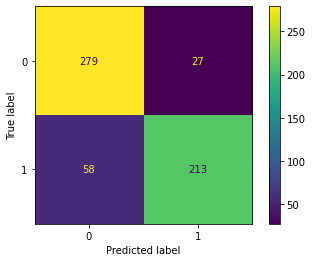

In [33]:
#confusion matrix

cm = confusion_matrix(y_test, y_pred, labels=kn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=kn.classes_)
disp.plot()
plt.show()

#### Gradient Boosting

In [34]:
clf = GradientBoostingClassifier()

clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [35]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91       306
           1       0.95      0.82      0.88       271

    accuracy                           0.90       577
   macro avg       0.91      0.89      0.90       577
weighted avg       0.90      0.90      0.90       577



In [36]:
#validação cruzada
X_to_cv = X_train.append(X_test)
y_to_cv = y_train.append(y_test)

scores = cross_val_score(clf, X_to_cv, y_to_cv, cv=5, scoring='accuracy')

print("acurácia de %0.2f com %0.2f desvios" % (scores.mean(), scores.std()))

acurácia de 0.90 com 0.01 desvios


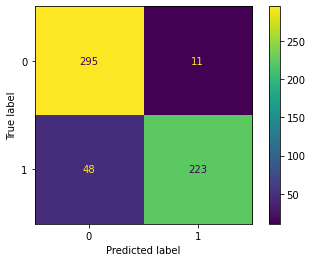

In [37]:
#confusion matrix

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

### Avaliação

Antes escolher o melhor modelo olhando qualquer métrica, vamos olhar para o problema:  

Uma instituição financeira busca classificar quantos clientes quitariam uma dívida de empréstimo, caso fosse concedido. Sendo assim, caso o modelo classificasse um indivíduo como apto e ele não fosse, seria um problema, pois esse usuário receberia o empréstimo e não pagaria. Então, podemos focar nosso critério de escolha olhando para a precisão, que responde a performance do modelo sob essa perspectiva.  

A precisão é a quantidade de verdadeiros positivos / falsos positivos. Em outras palavras, a precisão é a capacidade do classificador de não rotular como positiva uma amostra negativa. Ou seja, de todas as previsões positivas, ela resulta a proporção que realmente está correta.  

Dado que todos os modelos provaram sua capacidade de generalização (verificada pela validação cruzada, mantendo constante sua acurácia), o modelo com maior precisão foi o Gradient Boosting, com 95%.

## 2 - Predição de preços de diamantes

Vamos realizar alguuns processos de limpeza e padronização dos dados pra facilitar a manipulação. Aqui é importante se atentar as variáveis de texto que precisam ter um padrão pra não ser uma variável ruidoza para os modelos

In [54]:
raw = pd.read_csv('https://raw.githubusercontent.com/MLRG-CEFET-RJ/cic1205/main/data/diamonds.csv', sep=',', index_col = [0])

In [55]:
df = raw.copy()

In [56]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53940 entries, 1 to 53940
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.5+ MB


In [58]:
#lower nas var cat
categorical_data = df.select_dtypes('object').copy()
categorical_data_columns = categorical_data.columns

df.loc[:, categorical_data_columns] = categorical_data.apply(lambda x: x.astype(str).str.lower())

In [59]:
#limpeza dos textos: eliminando acentos
cols = df.select_dtypes("object").columns
df[cols] = df[cols].apply(lambda x: x.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8'))

In [60]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,ideal,e,si2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,premium,e,si1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,good,e,vs1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,premium,i,vs2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,good,j,si2,63.3,58.0,335,4.34,4.35,2.75


Verificando cardinalidade e se eventualemente a mesma palavra pode estar escrita de forma diferente

In [61]:
df.cut.value_counts()

ideal        21551
premium      13791
very good    12082
good          4906
fair          1610
Name: cut, dtype: int64

In [62]:
df.color.value_counts()

g    11292
e     9797
f     9542
h     8304
d     6775
i     5422
j     2808
Name: color, dtype: int64

In [63]:
df.clarity.value_counts()

si1     13065
vs2     12258
si2      9194
vs1      8171
vvs2     5066
vvs1     3655
if       1790
i1        741
Name: clarity, dtype: int64

Além disso, podemos checar a presença de multicolinearidade nas variáveis de entrada, já que essas variáveis precisam ser linearmente independentes. Fazemos isso checando a correlação (ou dependência) entre elas.

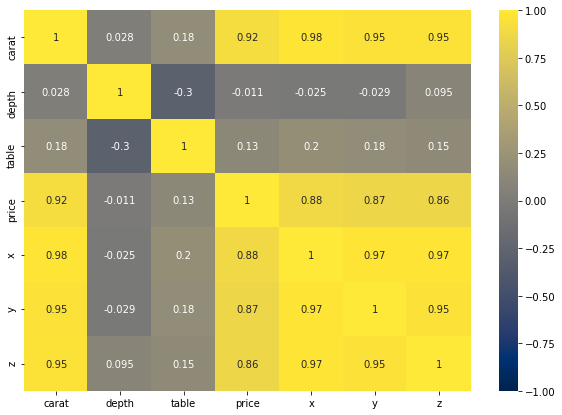

In [64]:
#matriz de correlação para as variáveis numéricas

var_num = df.select_dtypes(["float64","int64"])

plt.figure(figsize=(10, 7))
sns.heatmap(var_num.corr(), annot=True,vmin=-1, vmax=1,center= 0, cmap='cividis')
plt.show()

Para detectar a presença de multicolinearidade, além da matriz de correlação, podemos ultilizar o VIF (Variance Inflation Factor). O fator de inflação basicamente mede o grau em que cada variável independente é explicada pelas demais variáveis independentes. Quanto maior for o fator de inflação, mais severa será a multicolinearidade. Quando estamos trabalhando com uma regressão linear múltipla, é importante checar a correlação entre as variáveis independentes, pois caso estejam muito correlacionadas entre elas, poderemos ter sérios efeitos nas estimativas de MQO dos coeficientes, no qual os cálculos sobre a relevância e o peso dos parâmetros são feitos com pouca confiança.

In [65]:
#vif - multicolinearidade
vif = [variance_inflation_factor(var_num.values, i) for i in range(var_num.shape[1])]
vif_df = pd.DataFrame({'vif': vif[:]}, index=var_num.columns)

def highlight_max(s):
  is_max = s > 10
  return ['background-color: orange' if v else '' for v in is_max]

vif_df.style.apply(highlight_max)

,vif
carat,103.726117
depth,516.456375
table,501.097896
price,13.464526
x,1288.946580
y,531.485870
z,543.235912


Para fins didáticos, conforme pedido no exercício, seguirei sem remover nenhuma variável.

### Preparação pro fit

In [66]:
#separando variáveis
target = ['price']

dep_to_scaler = df.select_dtypes('float').columns
dep_cat = categorical_data_columns

In [67]:
#variaveis para predição
y = df[target]
X = df[dep_to_scaler].join(df[dep_cat])

Get dummy

In [68]:
#PRECISO TRANSFORMAR AS DUMMIES ANTES DO SPLIT PRA NÃO DAR CONFLITO DE TAMANHO DE COLUNAS NO X_test e X_train

X = pd.get_dummies(data=X, prefix=dep_cat, columns=dep_cat, drop_first=True)

Split

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [70]:
X_train.shape, X_test.shape

((43152, 23), (10788, 23))

Padronização dos dados

In [71]:
#TRANFORMER DEPOIS DO SPLIT PRA NÃO VAZAR DADOS DO TREINO PRO TESTE

#Scaler
scaler_train = StandardScaler()

#variaveis a serem transformadas
var_to_scaler = dep_to_scaler

#selecionando em cada dataset - treino e teste
data_transform_train = X_train[var_to_scaler].copy()
data_transform_test = X_test[var_to_scaler].copy()

#fit transform no dataset de treino e transform no dataset de teste
transformed_train = scaler_train.fit_transform(data_transform_train)
X_train.loc[:, var_to_scaler] = transformed_train

transformed_test = scaler_train.transform(data_transform_test)
X_test.loc[:, var_to_scaler] = transformed_test

### Treino e teste dos modelos

Algumas premissas para os modelos de regressão precisam ser cumpridas para que possamos confiar nos intervalos de confiança, algumas delas:  

i) destribuição normal dos resíduos;  
ii) expectativa dos resíduos é 0;  
iii) independência dos resíduos, ou seja, não deve existir autocorrelação entre os resíduos;  
iv) homecedasticidade, que pressupõe que para qualquer valor de X, a variância do resíduo deverá ser a mesma.  

Para testar a normalidade e homedasticidade dos resíduos, utilizaremos os seguintes testes:  

Jarque Bera: testa se os dados da amostra apresentam assimetria e curtose correspondentes a uma distribuição normal;  
Goldfeld-Quandt: testa se a variância residual é a mesma em 2 subamostras.

Para ambos os testes, um p-valor < 0,05 rejeita as hipóteses acima (nula).

Os testes serão realizados para todos os resultados.

#### Linear Regression

In [72]:
lr = LinearRegression()
model = lr.fit(X_train,y_train)

In [73]:
#coeficientes da regressão
coeficientes = model.coef_
colunas_coef = X_train.columns

df_coef = pd.DataFrame(coeficientes, columns = colunas_coef).T
df_coef.columns = ['coeficientes']

df_coef

,coeficientes
carat,5310.966331
depth,-87.981531
table,-56.201349
x,-1098.051008
y,2.047353
z,-22.835578
cut_good,595.314630
cut_ideal,851.037247
cut_premium,780.688139
cut_very good,752.509537


In [74]:
#previsão e resíduo
y_pred = model.predict(X_test)
resid = y_test - y_pred

Text(0.5, 1.0, 'Valores reais vs. preditos')

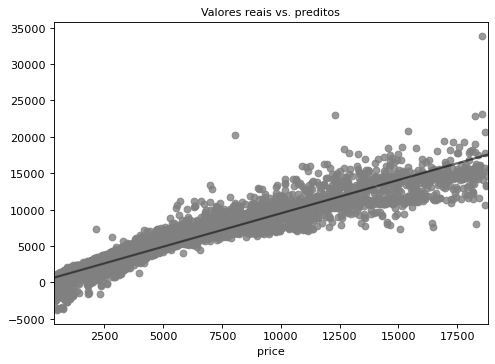

In [75]:
#visualizando valores preditos contra valores reais

plt.figure(figsize=(7, 5), dpi = 80)
sns.regplot(y_test, y_pred, color = "grey", line_kws={"color":"black","alpha":0.5,"lw":2})

plt.title("Valores reais vs. preditos",fontsize=10)

In [76]:
#métricas de avaliação e média do erro
print('r2:', round(r2_score(y_test, y_pred),2))
print('mse:', round(mean_squared_error(y_test, y_pred),2))
print('resid avg:', round(resid.mean()[0],2))

r2: 0.92
mse: 1215436.85
resid avg: -2.64


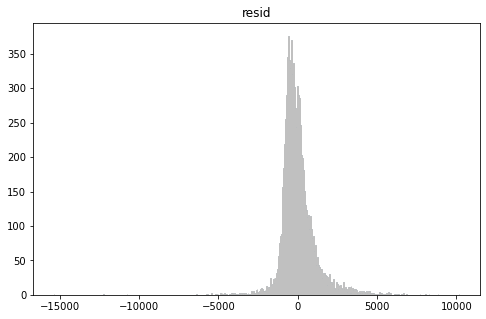

In [77]:
#normalidade do resíduo
plt.figure(figsize=(8,5))
plt.hist(resid,bins=500,edgecolor='silver')
plt.title("resid")
plt.show()

In [78]:
#teste de normalidade
print('jarque bera test:', round(jarque_bera(resid)[0],3))
print('p jarque bera:', jarque_bera(resid)[1])

jarque bera test: 68949.309
p jarque bera: 0.0


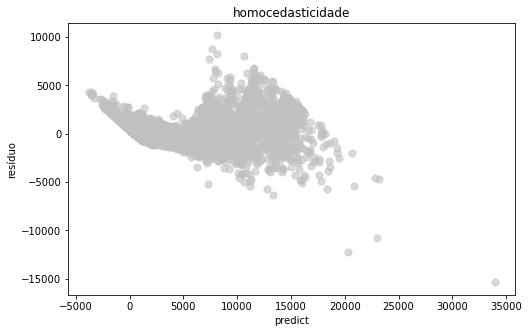

In [79]:
#vis homocedasticidade
plt.figure(figsize=(8,5))
plt.scatter(y=resid, x=y_pred, color='silver', s=50, alpha=.6)
plt.hlines(y=0, xmin=-10, xmax=15, color='orange')
plt.ylabel('resíduo')
plt.xlabel('predict')
plt.title("homocedasticidade")
plt.show()

In [80]:
#teste de homocedasticidade
print('goldfeld quandt test:', round(sms.het_goldfeldquandt(resid,X_test)[0],3))
print('p goldfeld quandt:', sms.het_goldfeldquandt(resid,X_test)[0])

goldfeld quandt test: 0.908
p goldfeld quandt: 0.9077505340861819


#### Lasso

In [81]:
ls = linear_model.Lasso()
model = ls.fit(X_train,y_train)

In [82]:
#coeficientes do modelo
coeficientes = model.coef_
colunas_coef = X_train.columns

df_coef = pd.DataFrame(coeficientes, index = colunas_coef)
df_coef.columns = ['coeficientes']

df_coef

,coeficientes
carat,5248.941822
depth,-96.643522
table,-62.564343
x,-1052.246620
y,-0.000000
z,-18.967059
cut_good,487.738949
cut_ideal,747.707397
cut_premium,675.917476
cut_very good,653.112730


In [83]:
#previsão e resíduo
y_pred = model.predict(X_test)
resid = y_test - y_pred.reshape(-1,1)

Text(0.5, 1.0, 'Valores reais vs. preditos')

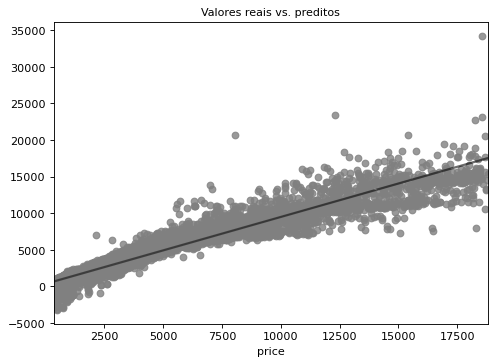

In [84]:
#visualizando valores preditos contra valores reais

plt.figure(figsize=(7, 5), dpi = 80)
sns.regplot(y_test, y_pred, color = "grey", line_kws={"color":"black","alpha":0.5,"lw":2})

plt.title("Valores reais vs. preditos",fontsize=10)

In [85]:
#métricas de avaliação e média do erro
print('r2:', round(r2_score(y_test, y_pred),2))
print('mse:', round(mean_squared_error(y_test, y_pred),2))
print('resid avg:', round(resid.mean()[0],2))

r2: 0.92
mse: 1213977.8
resid avg: -4.32


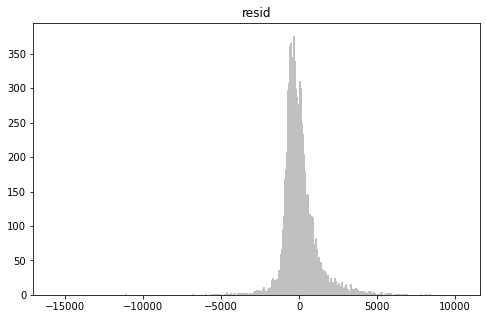

In [86]:
#normalidade do resíduo
plt.figure(figsize=(8,5))
plt.hist(resid,bins=500,edgecolor='silver')
plt.title("resid")
plt.show()

In [87]:
#teste de normalidade
print('jarque bera test:', round(jarque_bera(resid)[0],3))
print('p jarque bera:', jarque_bera(resid)[1])

jarque bera test: 80047.458
p jarque bera: 0.0


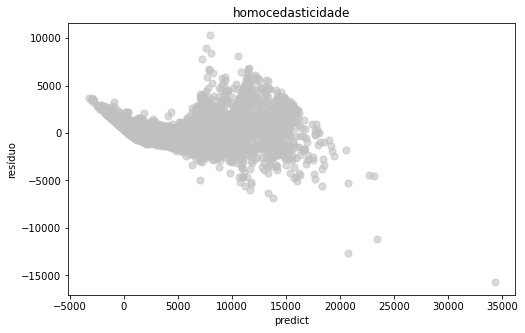

In [88]:
#vis homocedasticidade
plt.figure(figsize=(8,5))
plt.scatter(y=resid, x=y_pred, color='silver', s=50, alpha=.6)
plt.hlines(y=0, xmin=-10, xmax=15, color='orange')
plt.ylabel('resíduo')
plt.xlabel('predict')
plt.title("homocedasticidade")
plt.show()

In [89]:
#teste de homocedasticidade
print('goldfeld quandt test:', round(sms.het_goldfeldquandt(resid,X_test)[0],3))
print('p goldfeld quandt:', sms.het_goldfeldquandt(resid,X_test)[0])

goldfeld quandt test: 0.907
p goldfeld quandt: 0.9068658029177664


#### Decision Tree

In [90]:
clf_en = DecisionTreeRegressor(random_state=1)
model = clf_en.fit(X_train,y_train)

In [91]:
#importância das features
coeficientes = model.feature_importances_
colunas_coef = X_train.columns

df_coef = pd.DataFrame(coeficientes, index = colunas_coef)
df_coef.columns = ['feature importances']

df_coef

,feature importances
carat,0.625166
depth,0.004908
table,0.002663
x,0.005488
y,0.262505
z,0.006274
cut_good,0.000416
cut_ideal,0.001039
cut_premium,0.000468
cut_very good,0.000225


In [92]:
#previsão e resíduo
y_pred = model.predict(X_test)
resid = y_test - y_pred.reshape(-1,1)

Text(0.5, 1.0, 'Valores reais vs. preditos')

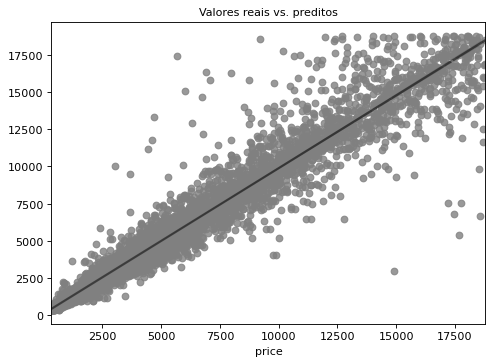

In [93]:
#visualizando valores preditos contra valores reais

plt.figure(figsize=(7, 5), dpi = 80)
sns.regplot(y_test, y_pred, color = "grey", line_kws={"color":"black","alpha":0.5,"lw":2})

plt.title("Valores reais vs. preditos",fontsize=10)

In [94]:
#métricas de avaliação e média do erro
print('r2:', round(r2_score(y_test, y_pred),2))
print('mse:', round(mean_squared_error(y_test, y_pred),2))
print('resid avg:', round(resid.mean()[0],2))

r2: 0.95
mse: 745048.04
resid avg: -5.04


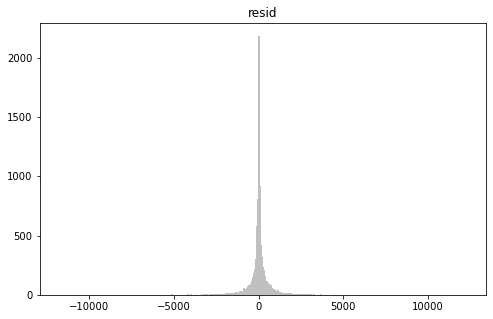

In [95]:
#normalidade do resíduo
plt.figure(figsize=(8,5))
plt.hist(resid,bins=500,edgecolor='silver')
plt.title("resid")
plt.show()

In [96]:
#teste de normalidade
print('jarque bera test:', round(jarque_bera(resid)[0],3))
print('p jarque bera:', jarque_bera(resid)[1])

jarque bera test: 687137.978
p jarque bera: 0.0


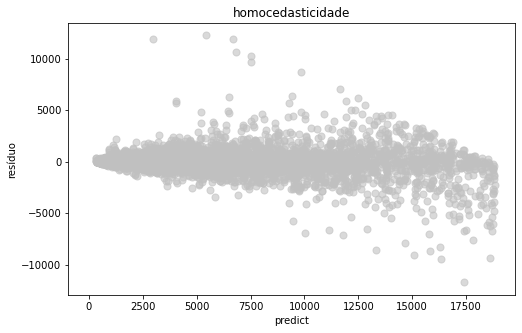

In [97]:
#vis homocedasticidade
plt.figure(figsize=(8,5))
plt.scatter(y=resid, x=y_pred, color='silver', s=50, alpha=.6)
plt.hlines(y=0, xmin=-10, xmax=15, color='orange')
plt.ylabel('resíduo')
plt.xlabel('predict')
plt.title("homocedasticidade")
plt.show()

In [98]:
#teste de homocedasticidade
print('goldfeld quandt test:', round(sms.het_goldfeldquandt(resid,X_test)[0],3))
print('p goldfeld quandt:', sms.het_goldfeldquandt(resid,X_test)[0])

goldfeld quandt test: 1.018
p goldfeld quandt: 1.017818930588353


#### Random Forest

In [99]:
rfg = RandomForestRegressor(random_state=1)
model = rfg.fit(X_train,y_train)

In [100]:
#importância das features
coeficientes = model.feature_importances_
colunas_coef = X_train.columns

df_coef = pd.DataFrame(coeficientes, index = colunas_coef)
df_coef.columns = ['feature importances']

df_coef

,feature importances
carat,0.543179
depth,0.006027
table,0.003026
x,0.006587
y,0.344180
z,0.006479
cut_good,0.000391
cut_ideal,0.001077
cut_premium,0.000449
cut_very good,0.000331


In [101]:
#previsão e resíduo
y_pred = model.predict(X_test)
resid = y_test - y_pred.reshape(-1,1)

Text(0.5, 1.0, 'Valores reais vs. preditos')

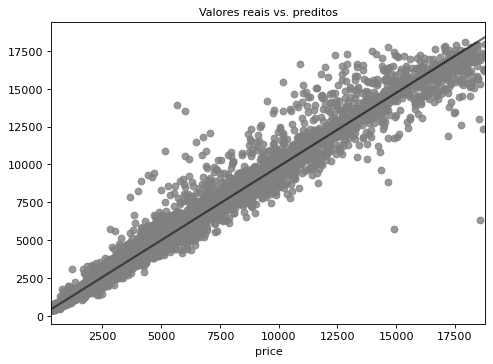

In [102]:
#visualizando valores preditos contra valores reais

plt.figure(figsize=(7, 5), dpi = 80)
sns.regplot(y_test, y_pred, color = "grey", line_kws={"color":"black","alpha":0.5,"lw":2})

plt.title("Valores reais vs. preditos",fontsize=10)

In [103]:
#métricas de avaliação e média do erro
print('r2:', round(r2_score(y_test, y_pred),2))
print('mse:', round(mean_squared_error(y_test, y_pred),2))
print('resid avg:', round(resid.mean()[0],2))

r2: 0.98
mse: 381887.34
resid avg: -5.35


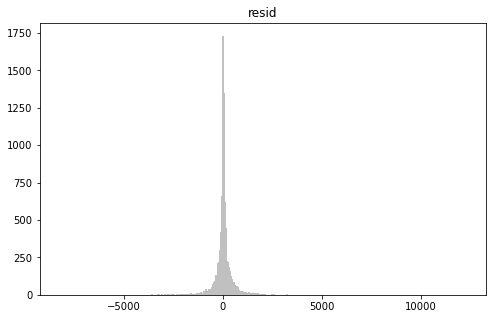

In [104]:
#normalidade do resíduo
plt.figure(figsize=(8,5))
plt.hist(resid,bins=500,edgecolor='silver')
plt.title("resid")
plt.show()

In [105]:
#teste de normalidade
print('jarque bera test:', round(jarque_bera(resid)[0],3))
print('p jarque bera:', jarque_bera(resid)[1])

jarque bera test: 736330.657
p jarque bera: 0.0


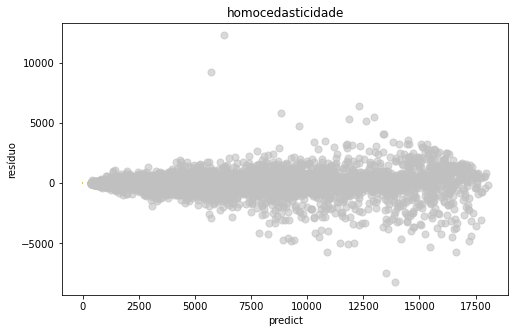

In [106]:
#vis homocedasticidade
plt.figure(figsize=(8,5))
plt.scatter(y=resid, x=y_pred, color='silver', s=50, alpha=.6)
plt.hlines(y=0, xmin=-10, xmax=15, color='orange')
plt.ylabel('resíduo')
plt.xlabel('predict')
plt.title("homocedasticidade")
plt.show()

In [107]:
#teste de homocedasticidade
print('goldfeld quandt test:', round(sms.het_goldfeldquandt(resid,X_test)[0],3))
print('p goldfeld quandt:', sms.het_goldfeldquandt(resid,X_test)[0])

goldfeld quandt test: 0.935
p goldfeld quandt: 0.9352058755190686


#### K Neighbors

In [108]:
kn = KNeighborsRegressor()
model = kn.fit(X_train,y_train)

In [109]:
#previsão e resíduo
y_pred = model.predict(X_test)
resid = y_test - y_pred.reshape(-1,1)

Text(0.5, 1.0, 'Valores reais vs. preditos')

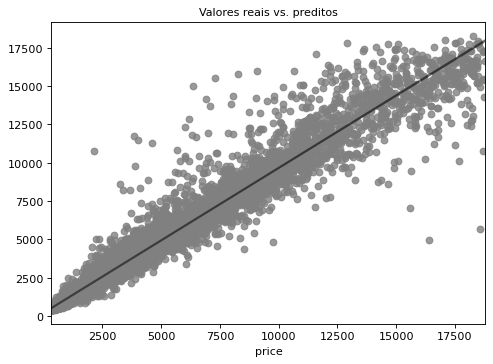

In [110]:
#visualizando valores preditos contra valores reais

plt.figure(figsize=(7, 5), dpi = 80)
sns.regplot(y_test, y_pred, color = "grey", line_kws={"color":"black","alpha":0.5,"lw":2})

plt.title("Valores reais vs. preditos",fontsize=10)

In [111]:
#métricas de avaliação e média do erro
print('r2:', round(r2_score(y_test, y_pred),2))
print('mse:', round(mean_squared_error(y_test, y_pred),2))
print('resid avg:', round(resid.mean()[0],2))

r2: 0.96
mse: 692358.0
resid avg: 15.51


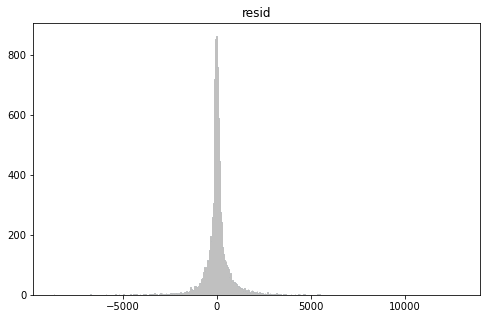

In [112]:
#normalidade do resíduo
plt.figure(figsize=(8,5))
plt.hist(resid,bins=500,edgecolor='silver')
plt.title("resid")
plt.show()

In [113]:
#teste de normalidade
print('jarque bera test:', round(jarque_bera(resid)[0],3))
print('p jarque bera:', jarque_bera(resid)[1])

jarque bera test: 342390.146
p jarque bera: 0.0


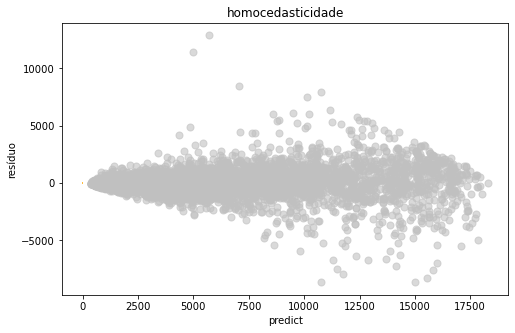

In [114]:
#vis homocedasticidade
plt.figure(figsize=(8,5))
plt.scatter(y=resid, x=y_pred, color='silver', s=50, alpha=.6)
plt.hlines(y=0, xmin=-10, xmax=15, color='orange')
plt.ylabel('resíduo')
plt.xlabel('predict')
plt.title("homocedasticidade")
plt.show()

In [115]:
#teste de homocedasticidade
print('goldfeld quandt test:', round(sms.het_goldfeldquandt(resid,X_test)[0],3))
print('p goldfeld quandt:', sms.het_goldfeldquandt(resid,X_test)[0])

goldfeld quandt test: 0.953
p goldfeld quandt: 0.9525088299024601


### Gradient Boosting

In [116]:
clf = GradientBoostingRegressor(random_state=0)
model = clf.fit(X_train,y_train)

In [117]:
#importância das features
coeficientes = model.feature_importances_
colunas_coef = X_train.columns

df_coef = pd.DataFrame(coeficientes, index = colunas_coef)
df_coef.columns = ['feature importances']

df_coef

,feature importances
carat,0.208050
depth,0.001412
table,0.000096
x,0.004942
y,0.691841
z,0.032439
cut_good,0.000000
cut_ideal,0.000488
cut_premium,0.000000
cut_very good,0.000000


In [118]:
#previsão e resíduo
y_pred = model.predict(X_test)
resid = y_test - y_pred.reshape(-1,1)

Text(0.5, 1.0, 'Valores reais vs. preditos')

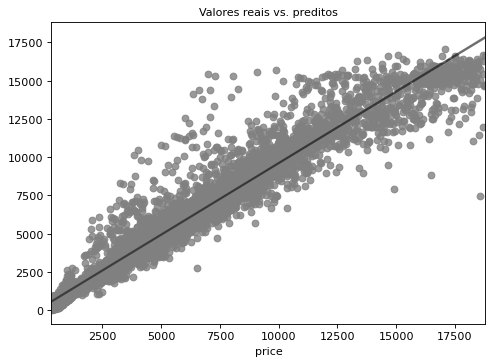

In [119]:
#visualizando valores preditos contra valores reais

plt.figure(figsize=(7, 5), dpi = 80)
sns.regplot(y_test, y_pred, color = "grey", line_kws={"color":"black","alpha":0.5,"lw":2})

plt.title("Valores reais vs. preditos",fontsize=10)

In [120]:
#métricas de avaliação e média do erro
print('r2:', round(r2_score(y_test, y_pred),2))
print('mse:', round(mean_squared_error(y_test, y_pred),2))
print('resid avg:', round(resid.mean()[0],2))

r2: 0.95
mse: 741049.67
resid avg: -0.99


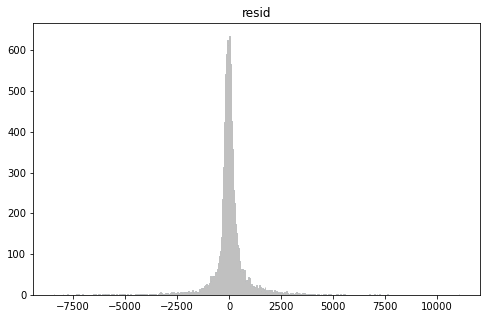

In [121]:
#normalidade do resíduo
plt.figure(figsize=(8,5))
plt.hist(resid,bins=500,edgecolor='silver')
plt.title("resid")
plt.show()

In [122]:
#teste de normalidade
print('jarque bera test:', round(jarque_bera(resid)[0],3))
print('p jarque bera:', jarque_bera(resid)[1])

jarque bera test: 157354.674
p jarque bera: 0.0


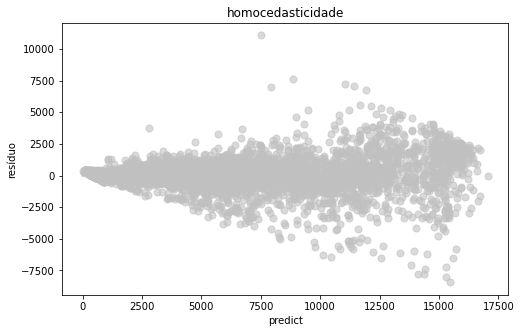

In [123]:
#vis homocedasticidade
plt.figure(figsize=(8,5))
plt.scatter(y=resid, x=y_pred, color='silver', s=50, alpha=.6)
plt.hlines(y=0, xmin=-10, xmax=15, color='orange')
plt.ylabel('resíduo')
plt.xlabel('predict')
plt.title("homocedasticidade")
plt.show()

In [124]:
#teste de homocedasticidade
print('goldfeld quandt test:', round(sms.het_goldfeldquandt(resid,X_test)[0],3))
print('p goldfeld quandt:', sms.het_goldfeldquandt(resid,X_test)[0])

goldfeld quandt test: 0.877
p goldfeld quandt: 0.877299723359954


### Avaliação

Para todos os modelos a homocedasticidade dos reíduos foi confirmada.
O mesmo não acontece para a normalidade dos resíduos, que não foi confirmada pelos testes para nenhum deles (e sabemos que em casos reais é bem difícil isso acontecer, pois dificilmente uma distribuição de ruído é EXATAMENTE uma normal). Dessa forma, podemos seguir com os modelos, mas sempre tendo em mente que os intervalos de confiança podem não ser confiáveis.  

Avaliando pelo R², todos eles apresentaram performance maior que 90%. Isso quer dizer que > 90% da variabilidade dos dados foi explicada pelos modelos.  

O modelo com melhor R² foi o Random Forest (98%), mas em contrapartida a distribuição dos resíduos é extremamente pontiaguda, o que distorce bastante os intervalos de confiança. Já o modelo de regressão linear apresentou R² de 92%, e com uma distribuição dos erros bem mais similar à normal, além de ter uma expectativa de erro bem próxima a 0 (resid avg). Talvez seja o melhor modelo a ser escolhido.

## 3 - Conjuntos desbalanceados

Para cada conjunto de dados, treinaremos o modelo nos dados desbalanceados e também utilizando 3 métodos de balanceamento. São eles:  

Oversampling: usando a técnica de sobreamostragem SMOTE (da biblioteca imbalanced-learn) que cria exemplos sintéticos para a classe minoritária, utilizando informações de vizinhos mais próximos.  

Undersampling: usando a técnica de subreamostragem NearMiss (da biblioteca imbalanced-learn) que refere-se a uma coleção de métodos de subamostragem que selecionam exemplos com base na distância da classe majoritária aos exemplos da classe minoritária, eliminando aleatoriamente exemplos de classes majoritária.  


Alteração de limiar: Ajuste no valor de decisão (limiar) que é usado para classificar as amostras em duas classes. Na prática, se a probabilidade estimada de pertencer a uma classe for maior que p 0,5, a amostra é atribuída a essa classe. A abordagem visa justamente em alterar esse p que chamamos de threshold.

Após aplicar as 3 técnicas, escolhi o melhor modelo com base na precisão da classe 1.


In [18]:
def to_binary(my_array):
    '''tranforma todos os valores do array que são diferentes de 0 em 1'''
    my_array[my_array != 0] = 1
    return my_array

### Conjunto 1

In [29]:
with open("dados/A602.pickle", "rb") as file:
    (X_train , y_train , X_val , y_val , X_test , y_test) = pickle.load(file)

In [30]:
y_train = to_binary(y_train)
y_val = to_binary(y_val)
y_test = to_binary(y_test)

In [31]:
clf = GradientBoostingClassifier(random_state=1)

clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [32]:
print('dados desbalanceados')
print(classification_report(y_test, y_pred))

dados desbalanceados
              precision    recall  f1-score   support

         0.0       0.94      0.91      0.93       673
         1.0       0.48      0.61      0.54        92

    accuracy                           0.87       765
   macro avg       0.71      0.76      0.73       765
weighted avg       0.89      0.87      0.88       765



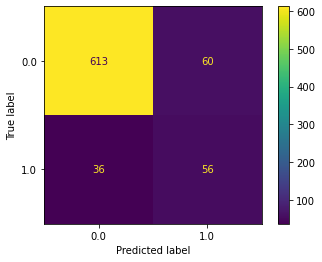

In [33]:
#confusion matrix

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

In [34]:
#oversampling | a classe minoritária representará 80% da classe minoritária

sm = SMOTE(sampling_strategy = 0.8, random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [35]:
clf = GradientBoostingClassifier(random_state=1)

clf.fit(X_res,y_res)
y_pred = clf.predict(X_test)

In [36]:
print('dados balanceados')
print(classification_report(y_test, y_pred))

dados balanceados
              precision    recall  f1-score   support

         0.0       0.94      0.88      0.91       673
         1.0       0.42      0.62      0.50        92

    accuracy                           0.85       765
   macro avg       0.68      0.75      0.71       765
weighted avg       0.88      0.85      0.86       765



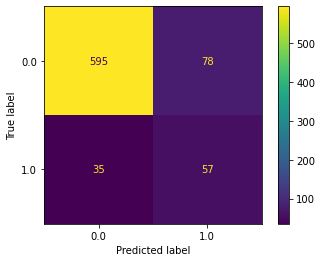

In [37]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

In [38]:
#undersamplig | a classe minoritária representará 80% da classe minoritária

nn = NearMiss(sampling_strategy = 0.8)
X_res, y_res = nn.fit_resample(X_train, y_train)

In [39]:
clf = GradientBoostingClassifier(random_state=1)

clf.fit(X_res,y_res)
y_pred = clf.predict(X_test)

In [40]:
print('dados balanceados')
print(classification_report(y_test, y_pred))

dados balanceados
              precision    recall  f1-score   support

         0.0       0.97      0.16      0.28       673
         1.0       0.14      0.97      0.24        92

    accuracy                           0.26       765
   macro avg       0.55      0.56      0.26       765
weighted avg       0.87      0.26      0.27       765



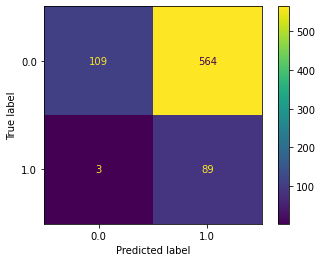

In [41]:
#confusion matrix

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

In [42]:
#alteração de limiar

clf = GradientBoostingClassifier(random_state=1)

model = clf.fit(X_train,y_train)
y_pred = model.predict(X_val)


In [43]:
thresholds = [0.25, 0.5, 0.75]
df_result_thr = pd.DataFrame(index = ['precision', 'recall', 'f1_score'])

for t in thresholds:

    probs = model.predict_proba(X_val)[:, 1]
    y_pred_new = (probs >= t).astype(int)

    precision_new = round(precision_score(y_val, y_pred_new), 2)
    recall_new = round(recall_score(y_val, y_pred_new), 2)
    f1_score_new = round(f1_score(y_val, y_pred_new), 2)

    data_thr = [precision_new,recall_new,f1_score_new]
    columns_name = ["threshold" +" "+str(t)]
    df_prov = pd.DataFrame(data = data_thr, columns = columns_name, index = ['precision', 'recall', 'f1_score'])
    
    df_result_thr = df_result_thr.join(df_prov)

In [44]:
df_result_thr

,threshold 0.25,threshold 0.5,threshold 0.75
precision,0.49,0.57,0.69
recall,0.77,0.70,0.58
f1_score,0.60,0.63,0.63


#### Avaliação

O modelo treinando no conjunto com alteração do threshold pra 0.75 foi o melhor, avaliando a precisão (69%).

### Conjunto 2

In [56]:
with open("dados/A621.pickle", "rb") as file:
    (X_train , y_train , X_val , y_val , X_test , y_test) = pickle.load(file)

In [57]:
y_train = to_binary(y_train)
y_val = to_binary(y_val)
y_test = to_binary(y_test)

In [58]:
clf = GradientBoostingClassifier(random_state=1)

clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [59]:
print('dados desbalanceados')
print(classification_report(y_test, y_pred))

dados desbalanceados
              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96      9147
         1.0       0.61      0.56      0.58       933

    accuracy                           0.93     10080
   macro avg       0.78      0.76      0.77     10080
weighted avg       0.92      0.93      0.92     10080



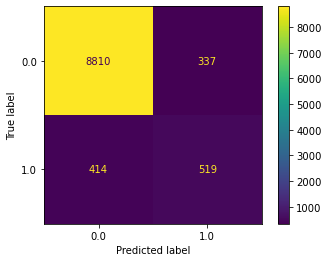

In [60]:
#confusion matrix

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

In [61]:
#oversampling | a classe minoritária representará 80% da classe minoritária

sm = SMOTE(sampling_strategy = 0.8, random_state=1)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [62]:
clf = GradientBoostingClassifier(random_state=1)

clf.fit(X_res,y_res)
y_pred = clf.predict(X_test)

In [63]:
print('dados balanceados')
print(classification_report(y_test, y_pred))

dados balanceados
              precision    recall  f1-score   support

         0.0       0.97      0.88      0.93      9147
         1.0       0.39      0.73      0.51       933

    accuracy                           0.87     10080
   macro avg       0.68      0.81      0.72     10080
weighted avg       0.92      0.87      0.89     10080



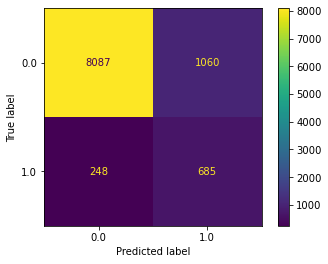

In [64]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

In [65]:
#undersamplig | a classe minoritária representará 80% da classe minoritária

nn = NearMiss(sampling_strategy = 0.8)
X_res, y_res = nn.fit_resample(X_train, y_train)

In [66]:
clf = GradientBoostingClassifier(random_state=1)

clf.fit(X_res,y_res)
y_pred = clf.predict(X_test)

In [67]:
print('dados balanceados')
print(classification_report(y_test, y_pred))

dados balanceados
              precision    recall  f1-score   support

         0.0       0.71      0.00      0.00      9147
         1.0       0.09      1.00      0.17       933

    accuracy                           0.09     10080
   macro avg       0.40      0.50      0.09     10080
weighted avg       0.66      0.09      0.02     10080



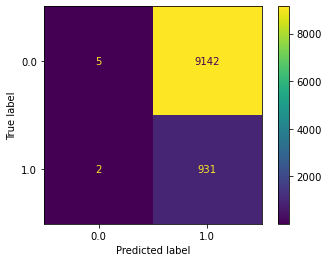

In [68]:
#confusion matrix

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

In [69]:
#alteração de limiar

clf = GradientBoostingClassifier(random_state=1)

model = clf.fit(X_train,y_train)
y_pred = model.predict(X_val)


In [70]:
thresholds = [0.25, 0.5, 0.75]
df_result_thr = pd.DataFrame(index = ['precision', 'recall', 'f1_score'])

for t in thresholds:

    probs = model.predict_proba(X_val)[:, 1]
    y_pred_new = (probs >= t).astype(int)

    precision_new = round(precision_score(y_val, y_pred_new), 2)
    recall_new = round(recall_score(y_val, y_pred_new), 2)
    f1_score_new = round(f1_score(y_val, y_pred_new), 2)

    data_thr = [precision_new,recall_new,f1_score_new]
    columns_name = ["threshold" +" "+str(t)]
    df_prov = pd.DataFrame(data = data_thr, columns = columns_name, index = ['precision', 'recall', 'f1_score'])
    
    df_result_thr = df_result_thr.join(df_prov)

In [71]:
df_result_thr

,threshold 0.25,threshold 0.5,threshold 0.75
precision,0.56,0.66,0.71
recall,0.66,0.50,0.30
f1_score,0.60,0.57,0.42


#### Avaliação

O modelo treinando no conjunto com alteração do threshold pra 0.75 foi o melhor, avaliando a precisão (71%).

### Conjunto 3

In [72]:
with open("dados/A627.pickle", "rb") as file:
    (X_train , y_train , X_val , y_val , X_test , y_test) = pickle.load(file)

In [73]:
y_train = to_binary(y_train)
y_val = to_binary(y_val)
y_test = to_binary(y_test)

In [74]:
clf = GradientBoostingClassifier(random_state=1)

clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [75]:
print('dados desbalanceados')
print(classification_report(y_test, y_pred))

dados desbalanceados
              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96      9200
         1.0       0.68      0.57      0.62      1002

    accuracy                           0.93     10202
   macro avg       0.82      0.77      0.79     10202
weighted avg       0.93      0.93      0.93     10202



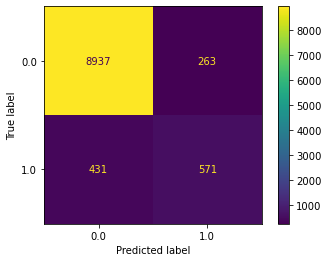

In [76]:
#confusion matrix

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

In [77]:
#oversampling | a classe minoritária representará 80% da classe minoritária

sm = SMOTE(sampling_strategy = 0.8, random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [78]:
clf = GradientBoostingClassifier(random_state=1)

clf.fit(X_res,y_res)
y_pred = clf.predict(X_test)

In [79]:
print('dados balanceados')
print(classification_report(y_test, y_pred))

dados balanceados
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.95      9200
         1.0       0.53      0.68      0.59      1002

    accuracy                           0.91     10202
   macro avg       0.75      0.81      0.77     10202
weighted avg       0.92      0.91      0.91     10202



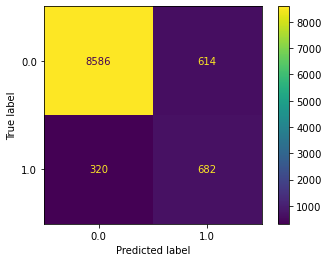

In [80]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

In [81]:
#undersamplig | a classe minoritária representará 80% da classe minoritária

nn = NearMiss(sampling_strategy = 0.8)
X_res, y_res = nn.fit_resample(X_train, y_train)

In [82]:
clf = GradientBoostingClassifier(random_state=1)

clf.fit(X_res,y_res)
y_pred = clf.predict(X_test)

In [83]:
print('dados balanceados')
print(classification_report(y_test, y_pred))

dados balanceados
              precision    recall  f1-score   support

         0.0       0.96      0.32      0.48      9200
         1.0       0.12      0.87      0.22      1002

    accuracy                           0.38     10202
   macro avg       0.54      0.60      0.35     10202
weighted avg       0.88      0.38      0.46     10202



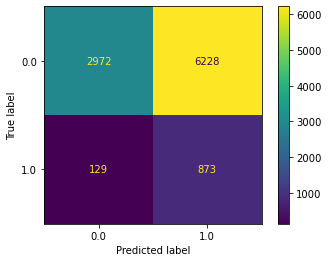

In [84]:
#confusion matrix

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

In [85]:
#alteração de limiar

clf = GradientBoostingClassifier(random_state=1)

model = clf.fit(X_train,y_train)
y_pred = model.predict(X_val)


In [86]:
thresholds = [0.25, 0.5, 0.75]
df_result_thr = pd.DataFrame(index = ['precision', 'recall', 'f1_score'])

for t in thresholds:

    probs = model.predict_proba(X_val)[:, 1]
    y_pred_new = (probs >= t).astype(int)

    precision_new = round(precision_score(y_val, y_pred_new), 2)
    recall_new = round(recall_score(y_val, y_pred_new), 2)
    f1_score_new = round(f1_score(y_val, y_pred_new), 2)

    data_thr = [precision_new,recall_new,f1_score_new]
    columns_name = ["threshold" +" "+str(t)]
    df_prov = pd.DataFrame(data = data_thr, columns = columns_name, index = ['precision', 'recall', 'f1_score'])
    
    df_result_thr = df_result_thr.join(df_prov)

In [87]:
df_result_thr

,threshold 0.25,threshold 0.5,threshold 0.75
precision,0.33,0.44,0.52
recall,0.76,0.65,0.41
f1_score,0.46,0.53,0.46


#### Avaliação

O modelo treinando no conjunto desbalanceado foi o melhor, avaliando a precisão (68%).

### Conjunto 4

In [88]:
with open("dados/A636.pickle", "rb") as file:
    (X_train , y_train , X_val , y_val , X_test , y_test) = pickle.load(file)

In [89]:
y_train = to_binary(y_train)
y_val = to_binary(y_val)
y_test = to_binary(y_test)

In [90]:
clf = GradientBoostingClassifier(random_state=1)

clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [91]:
print('dados desbalanceados')
print(classification_report(y_test, y_pred))

dados desbalanceados
              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96      9017
         1.0       0.67      0.56      0.61      1112

    accuracy                           0.92     10129
   macro avg       0.81      0.77      0.79     10129
weighted avg       0.92      0.92      0.92     10129



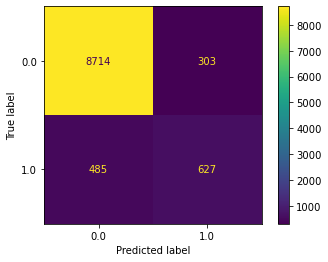

In [92]:
#confusion matrix

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

In [93]:
#oversampling | a classe minoritária representará 80% da classe minoritária

sm = SMOTE(sampling_strategy = 0.8, random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [94]:
clf = GradientBoostingClassifier(random_state=1)

clf.fit(X_res,y_res)
y_pred = clf.predict(X_test)

In [95]:
print('dados balanceados')
print(classification_report(y_test, y_pred))

dados balanceados
              precision    recall  f1-score   support

         0.0       0.96      0.81      0.88      9017
         1.0       0.32      0.74      0.45      1112

    accuracy                           0.80     10129
   macro avg       0.64      0.77      0.66     10129
weighted avg       0.89      0.80      0.83     10129



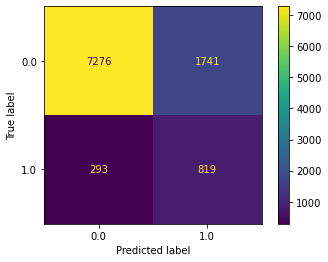

In [96]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

In [97]:
#undersamplig | a classe minoritária representará 80% da classe minoritária

nn = NearMiss(sampling_strategy = 0.8)
X_res, y_res = nn.fit_resample(X_train, y_train)

In [98]:
clf = GradientBoostingClassifier(random_state=1)

clf.fit(X_res,y_res)
y_pred = clf.predict(X_test)

In [99]:
print('dados balanceados')
print(classification_report(y_test, y_pred))

dados balanceados
              precision    recall  f1-score   support

         0.0       0.97      0.19      0.32      9017
         1.0       0.13      0.96      0.22      1112

    accuracy                           0.27     10129
   macro avg       0.55      0.57      0.27     10129
weighted avg       0.88      0.27      0.31     10129



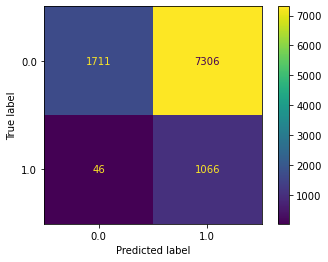

In [100]:
#confusion matrix

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

In [101]:
#alteração de limiar

clf = GradientBoostingClassifier(random_state=1)

model = clf.fit(X_train,y_train)
y_pred = model.predict(X_val)


In [102]:
thresholds = [0.25, 0.5, 0.75]
df_result_thr = pd.DataFrame(index = ['precision', 'recall', 'f1_score'])

for t in thresholds:

    probs = model.predict_proba(X_val)[:, 1]
    y_pred_new = (probs >= t).astype(int)

    precision_new = round(precision_score(y_val, y_pred_new), 2)
    recall_new = round(recall_score(y_val, y_pred_new), 2)
    f1_score_new = round(f1_score(y_val, y_pred_new), 2)

    data_thr = [precision_new,recall_new,f1_score_new]
    columns_name = ["threshold" +" "+str(t)]
    df_prov = pd.DataFrame(data = data_thr, columns = columns_name, index = ['precision', 'recall', 'f1_score'])
    
    df_result_thr = df_result_thr.join(df_prov)

In [103]:
df_result_thr

,threshold 0.25,threshold 0.5,threshold 0.75
precision,0.64,0.74,0.80
recall,0.70,0.58,0.40
f1_score,0.67,0.65,0.54


#### Avaliação

O modelo treinando no conjunto com alteração do threshold pra 0.75 foi o melhor, avaliando a precisão (80%).

### Conjunto 5

In [104]:
with open("dados/A652.pickle", "rb") as file:
    (X_train , y_train , X_val , y_val , X_test , y_test) = pickle.load(file)

In [105]:
y_train = to_binary(y_train)
y_val = to_binary(y_val)
y_test = to_binary(y_test)

In [106]:
clf = GradientBoostingClassifier(random_state=1)

clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [107]:
print('dados desbalanceados')
print(classification_report(y_test, y_pred))

dados desbalanceados
              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97      8769
         1.0       0.75      0.37      0.50       813

    accuracy                           0.94      9582
   macro avg       0.85      0.68      0.73      9582
weighted avg       0.93      0.94      0.93      9582



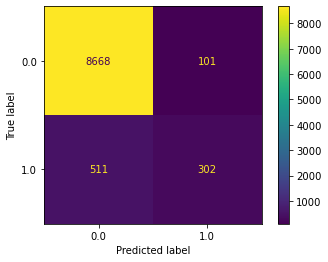

In [108]:
#confusion matrix

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

In [109]:
#oversampling | a classe minoritária representará 80% da classe minoritária

sm = SMOTE(sampling_strategy = 0.8, random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [110]:
clf = GradientBoostingClassifier(random_state=1)

clf.fit(X_res,y_res)
y_pred = clf.predict(X_test)

In [111]:
print('dados balanceados')
print(classification_report(y_test, y_pred))

dados balanceados
              precision    recall  f1-score   support

         0.0       0.97      0.94      0.96      8769
         1.0       0.52      0.66      0.58       813

    accuracy                           0.92      9582
   macro avg       0.74      0.80      0.77      9582
weighted avg       0.93      0.92      0.92      9582



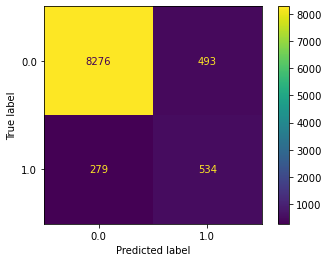

In [112]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

In [113]:
#undersamplig | a classe minoritária representará 80% da classe minoritária

nn = NearMiss(sampling_strategy = 0.8)
X_res, y_res = nn.fit_resample(X_train, y_train)

In [114]:
clf = GradientBoostingClassifier(random_state=1)

clf.fit(X_res,y_res)
y_pred = clf.predict(X_test)

In [115]:
print('dados balanceados')
print(classification_report(y_test, y_pred))

dados balanceados
              precision    recall  f1-score   support

         0.0       0.97      0.33      0.50      8769
         1.0       0.11      0.87      0.19       813

    accuracy                           0.38      9582
   macro avg       0.54      0.60      0.34      9582
weighted avg       0.89      0.38      0.47      9582



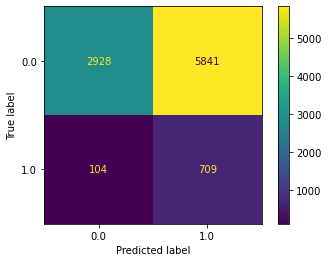

In [116]:
#confusion matrix

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

In [117]:
#alteração de limiar

clf = GradientBoostingClassifier(random_state=1)

model = clf.fit(X_train,y_train)
y_pred = model.predict(X_val)


In [118]:
thresholds = [0.25, 0.5, 0.75]
df_result_thr = pd.DataFrame(index = ['precision', 'recall', 'f1_score'])

for t in thresholds:

    probs = model.predict_proba(X_val)[:, 1]
    y_pred_new = (probs >= t).astype(int)

    precision_new = round(precision_score(y_val, y_pred_new), 2)
    recall_new = round(recall_score(y_val, y_pred_new), 2)
    f1_score_new = round(f1_score(y_val, y_pred_new), 2)

    data_thr = [precision_new,recall_new,f1_score_new]
    columns_name = ["threshold" +" "+str(t)]
    df_prov = pd.DataFrame(data = data_thr, columns = columns_name, index = ['precision', 'recall', 'f1_score'])
    
    df_result_thr = df_result_thr.join(df_prov)

In [119]:
df_result_thr

,threshold 0.25,threshold 0.5,threshold 0.75
precision,0.66,0.74,0.87
recall,0.63,0.40,0.14
f1_score,0.64,0.52,0.25


#### Avaliação

O modelo treinando no conjunto com alteração do threshold pra 0.75 foi o melhor, avaliando a precisão (87%).

Em nenhum dos conjuntos as abordagens de oversamplig e undersamplig foram as de molhor performance.

## 4 - Calibração de modelos

Um modelo é capaz de prever probabilidades, mas a distribuição e o comportamento das probabilidades nem sempre correspondem à distribuição esperada das probabilidades observadas. Diz-se que um modelo está perfeitamente calibrado se, para qualquer valor de probabilidade p, uma previsão de uma classe com confiança p estiver correta 100% das vezes. Sendo assim, a distribuição das probabilidades pode ser ajustada para melhor corresponder à distribuição esperada observada nos dados. Este ajuste é denominado calibração, ou seja, a capacidade de um modelo de classificação de fornecer estimativas de probabilidade precisas.

Para calibrar nosso modelo utilizarei 2 métodos: Sigmoid e Isotonic.

In [206]:
with open("dados/A652.pickle", "rb") as file:
    (X_train , y_train , X_val , y_val , X_test , y_test) = pickle.load(file)

In [207]:
y_train = to_binary(y_train)
y_val = to_binary(y_val)
y_test = to_binary(y_test)

In [208]:
clf = GradientBoostingClassifier()

model = clf.fit(X_train,y_train)
y_pred = model.predict(X_test)

probs = model.predict_proba(X_test)[:,1]

Função que plota as probabilidades

In [209]:
def plot_calibration_curve(name, fig_index, probs):
    """Plot calibration curve for est w/o and with calibration. """

    plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    
    frac_of_pos, mean_pred_value = calibration_curve(y_test, probs, n_bins=10)

    ax1.plot(mean_pred_value, frac_of_pos, "s-", label=f'{name}', color = "purple")
    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title(f'Calibration plot ({name})')

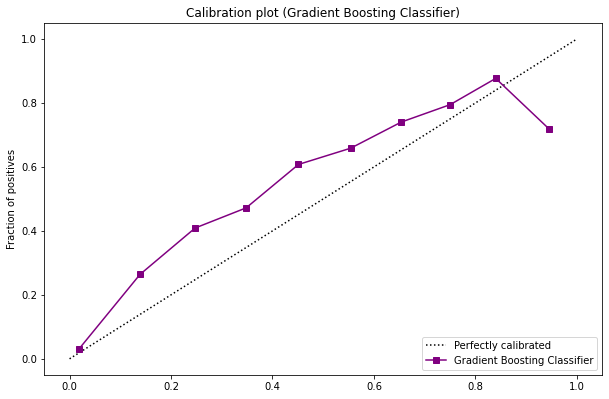

In [210]:
plot_calibration_curve("Gradient Boosting Classifier", 1, probs)

### Método 1: Sigmoid

O método sigmóide (escalonamento Platt) funciona transformando as saídas do classificador usando uma função sigmóide e é menos propenso a overfitting. Na prática, realizamos regressão logística na saída do modelo, ou seja, simplesmente ajustamos um classificador de regressão logística usando as saídas (0 ou 1) do modelo original.

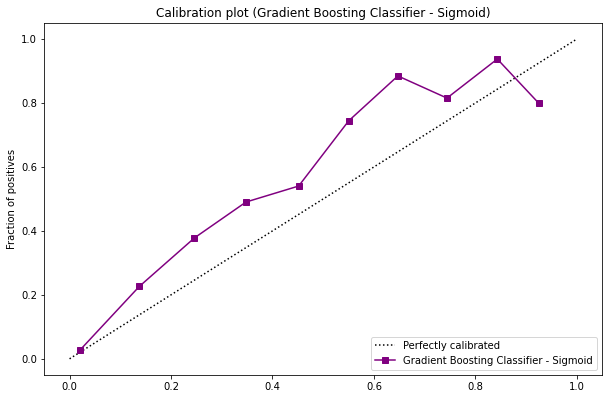

In [211]:
platts_scaling = CalibratedClassifierCV(model, cv=5, method='sigmoid')
platts_scaling.fit(X_train, y_train)
calibrated_probs = platts_scaling.predict_proba(X_test)[:,1]

plot_calibration_curve("Gradient Boosting Classifier - Sigmoid", 3, calibrated_probs)

### Método 2: Isotonic

A regressão isotônica é uma variação da regressão de mínimos quadrados e é frequentemente usada em situações em que se sabe que a relação entre as variáveis ​preditoras e de saída é monotônica, mas a forma exata da relação é desconhecida. Um benefício da regressão isotônica é que ela não é restringida por nenhuma forma funcional, como a linearidade imposta pela regressão linear, desde que a função seja monotônica crescente.

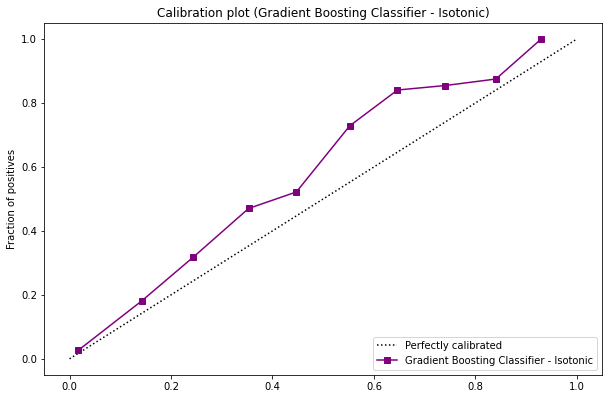

In [212]:
platts_scaling = CalibratedClassifierCV(model, cv=5, method='isotonic')
platts_scaling.fit(X_train, y_train)
calibrated_probs = platts_scaling.predict_proba(X_test)[:,1]

plot_calibration_curve("Gradient Boosting Classifier - Isotonic", 3, calibrated_probs)

### Avaliação

O modelo calibrado pelo método Isotonic se aproxima mais a um modelo "perfeitamente" calibrado. Sendo assim, esse modelo está mais apto a fornecer distribuições de probabilidade mais precisas. 

## 5 - Busca de hiperparâmetros

Para buscar melhores hiperparâmetros pro modelo, usarei o GridSearch, que a partir de valores pré determinados pra cada hiperparâmetro, testa todas as combiações possíveis e encontra a melhor combinação entre elas.

In [213]:
with open("dados/A652.pickle", "rb") as file:
    (X_train , y_train , X_val , y_val , X_test , y_test) = pickle.load(file)

In [214]:
y_train = to_binary(y_train)
y_val = to_binary(y_val)
y_test = to_binary(y_test)

Modelo Default

In [215]:
rfg = RandomForestClassifier(random_state = 1) 
rfg.fit(X_train, y_train)

y_pred = rfg.predict(X_test)

In [216]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97      8769
         1.0       0.80      0.31      0.44       813

    accuracy                           0.93      9582
   macro avg       0.87      0.65      0.71      9582
weighted avg       0.93      0.93      0.92      9582



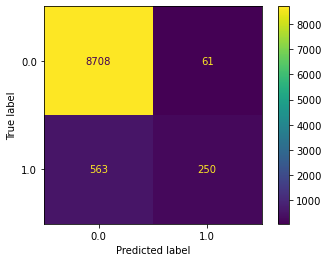

In [217]:
#confusion matrix

cm = confusion_matrix(y_test, y_pred, labels=rfg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rfg.classes_)
disp.plot()
plt.show()

 Abaixo, vou instanciar novamente o modelo e delimitar um dicionário com valores para os hiperparâmetros, para o o GridSearch encontre essa combinação ótima.

In [218]:
rfg = RandomForestClassifier(random_state = 1)

In [219]:
#hiperparâmetos a serem explorados

param_grid = { 
    'criterion': ['gini','entropy','log_loss']
    ,'n_estimators': [200,300,500]
    ,'max_features': ['auto', 'sqrt', 'log2']
    ,'max_depth': [4,5,6,7,8]
    ,"min_samples_split": [2,3,4]
    ,"min_samples_leaf": [1,2,3]
}

Importante saber:

criterion - função pra medir o critério de divisão
n_estimators - número de árvores na floresta;  
max_features - o número de features a serem considerados ao procurar a melhor divisão;  
max_depth - profundidade máxima das árvores;  
min_samples_split - número mínimo de amostras necessárias para dividir um nó interno;  
min_samples_leaf - o número mínimo de amostras necessárias para estar em um nó folha;  

In [201]:
grid = GridSearchCV(estimator = rfg, param_grid = param_grid, cv = 5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [200, 300, 500]})

In [203]:
#melhores hiperparâmetros

grid.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 300}

In [204]:
#melhor modelo

grid.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=8, max_features='auto',
                       min_samples_split=4, n_estimators=300, random_state=1)

Como a busca por melhores hiperparâmetros usando o GridSearch pode ser um processo lento (a depender da quantidade de hiperparâmetros a ser explorada), podemos salvá-lo em um pickle para que, caso precisemos fazer mais explorações usando esse estimador em outro momento, não seja preciso realizar a busca novamente.

Salvando

In [ ]:
#pickle.dump(grid.best_estimator_, open("grid_best_estimator", 'wb'))

Lendo o estimador previamente salvo e ajustando ele aos dados

In [220]:
rfg_grid = pickle.load(open("grid_best_estimator", "rb"))

In [221]:
rfg_grid.fit(X_train, y_train)
y_pred = rfg_grid.predict(X_test)

In [222]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97      8769
         1.0       0.83      0.28      0.42       813

    accuracy                           0.93      9582
   macro avg       0.89      0.64      0.69      9582
weighted avg       0.93      0.93      0.92      9582



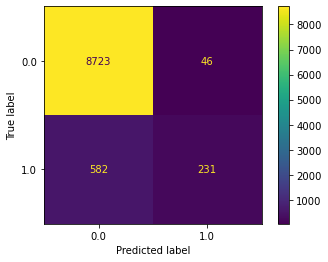

In [223]:
#confusion matrix

cm = confusion_matrix(y_test, y_pred, labels=rfg_grid.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rfg_grid.classes_)
disp.plot()
plt.show()

Tivemos um ganho bem expressivo na performance do modelo. Usando o modelo com hiperparâmetros default temos uma precisão de 80%. Usando o GridSearch pra buscar melhores combinações, chegamos a uma precisão de 83%, aumento de 3p.p.